In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"


import jax
from openqdc.datasets import SpiceV2 as Spice

from physnetjax.data.datasets import process_in_memory
from physnetjax.models.model import EF
from physnetjax.training.training import train_model

# Configurable Constants
NATOMS = 110
DEFAULT_DATA_KEYS = ["Z", "R", "D", "E", "F", "N"]
RANDOM_SEED = 42
BATCH_SIZE = 20

# # Environment configuration
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# JAX Configuration Check
def check_jax_configuration():
    devices = jax.local_devices()
    print("Devices:", devices)
    print("Default Backend:", jax.default_backend())
    print("All Devices:", jax.devices())


check_jax_configuration()



# Dataset preparation
def prepare_spice_dataset(dataset, subsample_size, max_atoms):
    """Prepare the dataset by preprocessing and subsampling."""
    d = dataset.subsample(subsample_size)
    d = [dict(ds[_]) for _ in d]
    return process_in_memory(d, max_atoms=max_atoms)


ds = Spice(energy_unit="ev", distance_unit="ang", array_format="jax")
ds.read_preprocess()
output1 = prepare_spice_dataset(ds, subsample_size=100_00, max_atoms=NATOMS)
output2 = prepare_spice_dataset(ds, subsample_size=100, max_atoms=NATOMS)

# Random key initialization
data_key, train_key = jax.random.split(jax.random.PRNGKey(RANDOM_SEED), 2)





2024-12-19 23:19:46.246817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734646786.269377 2227379 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734646786.276286 2227379 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 23:19:50.838044: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:1: CUDA error: : CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
2024-12-19 23:19:50.946 | INFO     | openqdc.datasets.base:read_preprocess:435 - Reading preprocessed data.
2024-12-19 23:19:50.947 | INFO     | openqdc.datasets.base:read_preprocess:436 - Dataset spicev2 with the followi

Devices: [CudaDevice(id=0)]
Default Backend: gpu
All Devices: [CudaDevice(id=0)]


2024-12-19 23:19:54.048 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded atomic_inputs with shape (70428909, 5), dtype float32
2024-12-19 23:19:54.049 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded position_idx_range with shape (2008628, 2), dtype int32
2024-12-19 23:19:54.050 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded energies with shape (2008628, 1), dtype float64
2024-12-19 23:19:54.050 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded forces with shape (70428909, 3, 1), dtype float32
2024-12-19 23:19:54.051 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded subset with shape (2008628,), dtype <U21
2024-12-19 23:19:54.052 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded n_atoms with shape (2008628,), dtype int32
2024-12-19 23:19:54.052 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded name with shape (2008628,), dtype <U800
2024-12-19 23:19:56.328 | INFO     | openqdc.dataset

In [76]:
dir(ds)
ds._e0s_dispatcher[1]

AtomEnergy(mean=array([-0.49876052], dtype=float32), std=array([1.], dtype=float32))

In [74]:
ds[0]

{'positions': Array([[  7.7726045 ,  -5.589646  ,   1.0528611 ],
        [ 13.361319  ,   2.2602162 ,   1.2856807 ],
        [  9.137465  ,  -5.463722  ,   2.9197867 ],
        [ 12.452677  ,   0.87481827,   2.8991485 ],
        [  1.859187  ,   1.0621266 ,  -2.3895817 ],
        [-11.91162   ,  -5.8753314 ,  -4.713819  ],
        [ -9.329574  ,  -5.339668  ,  -4.671536  ],
        [-13.629418  ,  -4.11381   ,  -3.7631032 ],
        [ -8.471734  ,  -3.0405872 ,  -3.6900208 ],
        [-12.766283  ,  -1.816972  ,  -2.7803066 ],
        [-10.173047  ,  -1.220601  ,  -2.748577  ],
        [  2.9785464 ,   1.7483501 ,  -4.47574   ],
        [ 13.186451  ,   0.9084559 ,   5.320979  ],
        [  2.6562583 ,   1.8136618 ,  -0.14374393],
        [ -7.54156   ,  -1.1701832 ,   2.0282698 ],
        [ 10.342084  ,  -3.354371  ,   3.6241736 ],
        [ -0.10963301,  -0.40304434,  -2.586922  ],
        [  9.49612   ,  -7.7465706 ,   4.5945454 ],
        [ 15.157833  ,   2.5538468 ,   6.3567424 ],

In [3]:
batch_kwargs = {
    "batch_shape" : int((BATCH_SIZE - 1) * NATOMS),
    "nb_len" : int((NATOMS * (NATOMS - 1) * (BATCH_SIZE - 1)) // 1.6)
}

print("Model initialized")
print(batch_kwargs)


batch_method = "advanced"
if batch_method == "advanced" and isinstance(batch_kwargs, dict) and \
    "batch_shape" in batch_kwargs and "nb_len" in batch_kwargs:
    print("Using advanced batching method")
    from physnetjax.data.batches import prepare_batches_advanced_minibatching
    def _prepare_batches(x):
        return prepare_batches_advanced_minibatching(
        x["key"],
        x["data"],
        x["batch_size"],
        batch_kwargs["batch_shape"],
        batch_kwargs["nb_len"],
        num_atoms=x["num_atoms"],
        data_keys=x["data_keys"],
    )
else:
    print("Using default batching method")
    from physnetjax.data.batches import get_prepare_batches_fn
    _prepare_batches = get_prepare_batches_fn()
    

Model initialized
{'batch_shape': 2090, 'nb_len': 142381}
Using advanced batching method


shape: (44, 16)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────┬───────────┐
│ valid_ener ┆ valid_forc ┆ train_ener ┆ train_for ┆ … ┆ dipole_w  ┆ forces_w  ┆ epoch ┆ log       │
│ gy_mae     ┆ es_mae     ┆ gy_mae     ┆ ces_mae   ┆   ┆ ---       ┆ ---       ┆ ---   ┆ ---       │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆   ┆ f64       ┆ f64       ┆ i64   ┆ str       │
│ f64        ┆ f64        ┆ f64        ┆ f64       ┆   ┆           ┆           ┆       ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════╪═══════════╡
│ 0.426737   ┆ 0.139726   ┆ 0.5305     ┆ 0.160958  ┆ … ┆ 27.211386 ┆ 52.917721 ┆ 0     ┆ /pchem-da │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /boittier │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /ho…      │
│ 0.44697    ┆ 0.127407   ┆ 0.531543   ┆ 0.134289  ┆ … ┆ 27.211386 ┆ 52.917721 ┆ 1     ┆ /pchem-da │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /boittier │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /ho…      │
│ 0.445875   ┆ 0.121669   ┆ 0.52092    ┆ 0.126271  ┆ … ┆ 27.211386 ┆ 52.917721 ┆ 2     ┆ /pchem-da │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /boittier │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /ho…      │
│ 0.443778   ┆ 0.117549   ┆ 0.51458    ┆ 0.121857  ┆ … ┆ 27.211386 ┆ 52.917721 ┆ 3     ┆ /pchem-da │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /boittier │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /ho…      │
│ 0.442728   ┆ 0.114982   ┆ 0.514468   ┆ 0.118456  ┆ … ┆ 27.211386 ┆ 52.917721 ┆ 4     ┆ /pchem-da │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /boittier │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /ho…      │
│ …          ┆ …          ┆ …          ┆ …         ┆ … ┆ …         ┆ …         ┆ …     ┆ …         │
│ 0.450735   ┆ 0.093673   ┆ 0.492471   ┆ 0.095219  ┆ … ┆ 27.211386 ┆ 52.917721 ┆ 39    ┆ /pchem-da │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /boittier │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /ho…      │
│ 0.450079   ┆ 0.093561   ┆ 0.494704   ┆ 0.094973  ┆ … ┆ 27.211386 ┆ 52.917721 ┆ 40    ┆ /pchem-da │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /boittier │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /ho…      │
│ 0.451488   ┆ 0.093229   ┆ 0.493141   ┆ 0.095002  ┆ … ┆ 27.211386 ┆ 52.917721 ┆ 41    ┆ /pchem-da │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /boittier │
│            ┆            ┆            ┆           ┆   ┆           ┆           ┆       ┆ /ho…      │
│ 0.449032   ┆ 0.093044   ┆ 0.492752   ┆ 0.09

╭─────────────────── ~~ Log10 Loss ~~ ───────────────────╮
│ -1.96e+00 ┤                                            │
│ -2.05e+00 ┼╮                                           │
│ -2.15e+00 ┤╰─╮                                         │
│ -2.24e+00 ┤  ╰──────╮╮                                 │
│ -2.34e+00 ┤         ╰──────────────────────────────╮── │
│ -2.43e+00 ┤                                        ╰── │
╰────────────────────────────────────────────────────────╯

╭──────────────── ~~ Log10 Energy MAE ~~ ────────────────╮
│ -2.74e-01 ┤                                            │
│ -2.94e-01 ┼───────╮                                    │
│ -3.13e-01 ┤       ╰─────────────────────────────────── │
│ -3.32e-01 ┤                                        ╭╮  │
│ -3.51e-01 ┤╭───────────────────────────────────────╯╰─ │
│ -3.70e-01 ┤╯                                           │
╰────────────────────────────────────────────────────────╯

╭──────────────── ~~ Log10 Forces MAE ~~ ────────────────╮
│ -7.93e-01 ┼╮                                           │
│ -8.41e-01 ┤╮                                           │
│ -8.89e-01 ┤╰─╮╮                                        │
│ -9.37e-01 ┤  ╰──────────╮───╮                          │
│ -9.84e-01 ┤             ╰───────────────────────────── │
│ -1.03e+00 ┤                                            │
╰────────────────────────────────────────────────────────╯

╭───────────────── ~~ Learning Rate ~~ ─────────────────╮
│ 1.00e-03 ┼                                            │
│ 1.00e-03 ┼─────────────────────────────────────────── │
╰───────────────────────────────────────────────────────╯

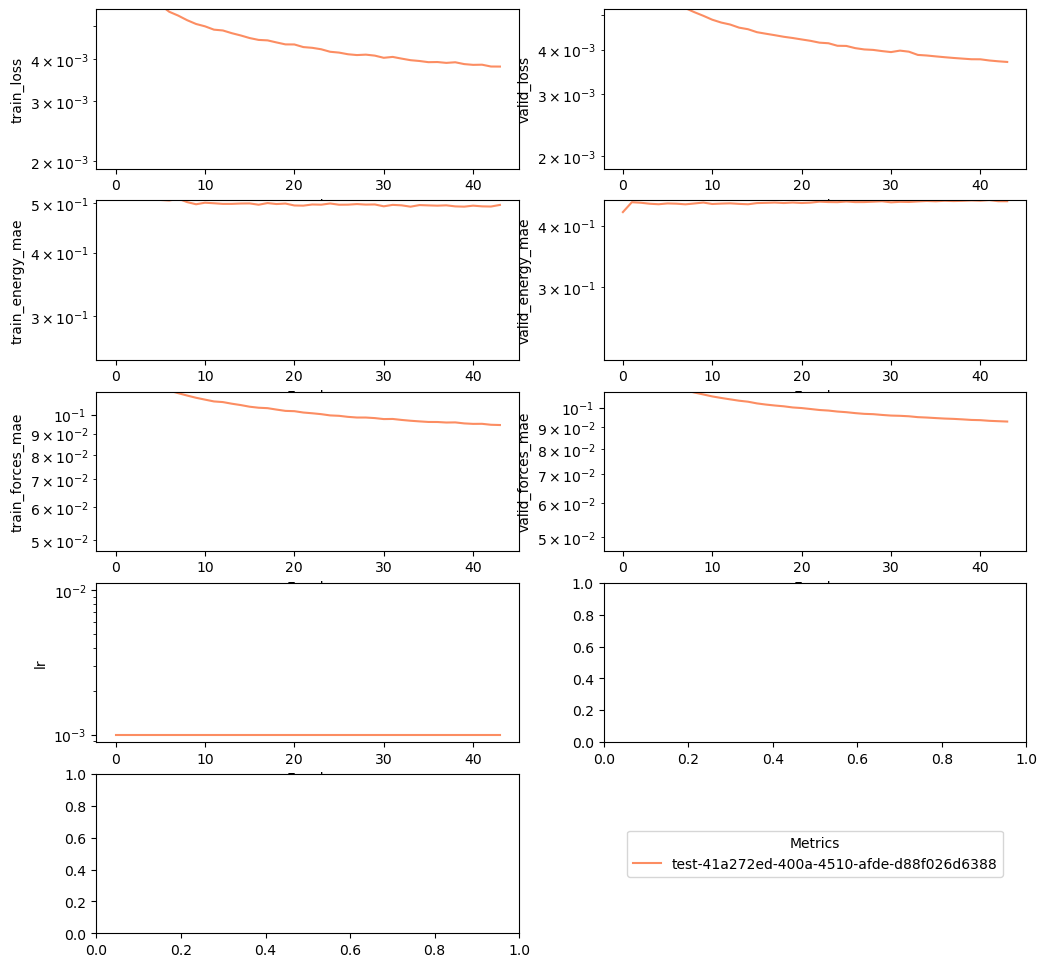

In [18]:
from argparse import ArgumentParser
from pathlib import Path
from physnetjax.analysis.plot_run import plot_run
import polars as pl
import matplotlib.pyplot as plt
from physnetjax.directories import LOGS_PATH, BASE_CKPT_DIR
from physnetjax.logger.tensorboard_interface import process_tensorboard_logs

logs_path = BASE_CKPT_DIR / "test-41a272ed-400a-4510-afde-d88f026d6388" / "tfevents"
key = logs_path.parent.name
df = process_tensorboard_logs(logs_path)

# pretty print polars dataframe with rich
from rich.console import Console

console = Console()
console.print(df)

fig, ax = plt.subplots(5, 2, figsize=(12, 12))
plot_run(df, ax, 1, key, log=True)
# save the plot
save_path = LOGS_PATH / key / "tf_logs.png"
# make the directory if it does not exist
save_path.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(save_path, bbox_inches="tight")
# save the dataframe as a csv
df.write_csv(LOGS_PATH / key / "tf_logs.csv")


In [28]:

data_key, train_key = jax.random.split(jax.random.PRNGKey(RANDOM_SEED), 2)
key, shuffle_key = jax.random.split(data_key)
kwargs = {
    "key": shuffle_key,
    "data": output2,
    "batch_size": 1,
    "num_atoms": 1110,
    "data_keys": ("R", "Z", "F", "E", "dst_idx", "src_idx", "batch_segments"),
}
if batch_method == "advanced":
    kwargs.update(batch_kwargs)
valid_batches = _prepare_batches(
    kwargs
)

In [29]:
valid_batches[0]

{'dst_idx': array([   0,    0,    0, ..., 2091, 2091, 2091]),
 'src_idx': array([   1,    2,    3, ..., 2091, 2091, 2091]),
 'batch_mask': array([1, 1, 1, ..., 0, 0, 0]),
 'R': array([[2.44991684, 3.95941114, 4.99431944],
        [1.98474169, 2.01168919, 6.48920631],
        [0.83988881, 3.6539557 , 2.97601628],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]),
 'Z': array([7, 6, 6, ..., 0, 0, 0], dtype=int32),
 'F': array([[ 1.07627682e-01,  1.38024718e-01, -4.21638979e-04],
        [-9.99011463e-05,  2.51281750e-03, -3.84500134e-03],
        [ 1.69429276e-02,  2.15207203e-03,  1.31636271e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'E': array([0.]),
 'atom_mask': Array([1, 1, 1, ..., 0, 0, 0], dtype=int32, weak_type=True),
 '

In [30]:
restart = BASE_CKPT_DIR / "test-41a272ed-400a-4510-afde-d88f026d6388" / "epoch-42"

In [31]:
from physnetjax.restart.restart import get_params_model

params, model = get_params_model(restart, natoms=110)

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 5.0    │ False │ False │ 128    │ 70     │ 0      │ 2     │ 110    │ 16     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                        ┃ name     ┃ epoch ┃ best_loss   ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm_test/c… │ epoch-42 │ 42    │ 0.003730495 │ 2024-12-20 00:15:26.209004 │
└───────────────────────────────────────────────────┴──────────┴───────┴─────────────┴────────────────────────────┘

In [32]:
import numpy as np
energies = np.array([_["E"] for _ in valid_batches])

(array([[25],
        [ 3],
        [30],
        [20],
        [40],
        [48],
        [44],
        [33],
        [13],
        [41],
        [50],
        [49],
        [44],
        [49],
        [54],
        [49],
        [37],
        [47],
        [22],
        [47],
        [24],
        [17],
        [34],
        [24],
        [36],
        [36],
        [41],
        [37],
        [39],
        [30],
        [25],
        [42],
        [41],
        [24],
        [37],
        [71],
        [39],
        [36],
        [21],
        [11],
        [16],
        [16],
        [51],
        [49],
        [27],
        [15],
        [ 8],
        [49],
        [36],
        [45],
        [39],
        [48],
        [37],
        [42],
        [24],
        [25],
        [48],
        [28],
        [44],
        [12],
        [50],
        [22],
        [45],
        [ 2],
        [ 9],
        [61],
        [50],
        [32],
        [ 8],
        [44],
        [48],
      

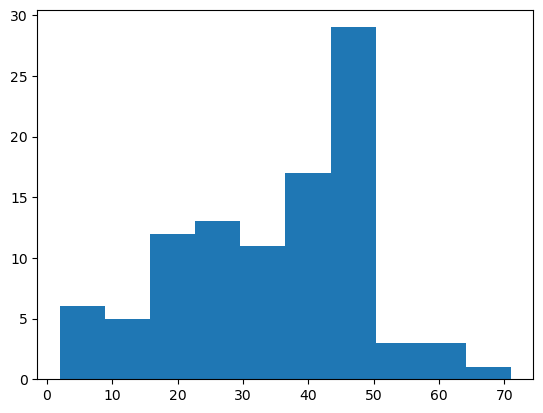

In [121]:
ns = np.vstack([_["N"] for _ in valid_batches])
nonzero = np.nonzero(ns.flatten())[0]
plt.hist(ns.flatten()[nonzero])
ns, energies

In [122]:
# plt.hist(output2["E"])
# ds._e0s_dispatcher[output2["Z"][0]]
print(ds[0]["energies"], 512.6264  * 0.0367492929)
print(ds[0]["energies"] - ds[0]["e0"].sum() * 0.0367492929  )
print(ds[0]["e0"].sum() - 512.6264 )
print(ds[0])
ds[0]["e0"].sum() * 0.0367492929, [np.array([ds._e0s_dispatcher[int(_)].mean for _ in ds[0]["atomic_numbers"] if _ != 0]).sum() ]

[-1302.2228] 18.83865772187256
[-11.015381]
-35648.195
{'positions': Array([[  7.7726045 ,  -5.589646  ,   1.0528611 ],
       [ 13.361319  ,   2.2602162 ,   1.2856807 ],
       [  9.137465  ,  -5.463722  ,   2.9197867 ],
       [ 12.452677  ,   0.87481827,   2.8991485 ],
       [  1.859187  ,   1.0621266 ,  -2.3895817 ],
       [-11.91162   ,  -5.8753314 ,  -4.713819  ],
       [ -9.329574  ,  -5.339668  ,  -4.671536  ],
       [-13.629418  ,  -4.11381   ,  -3.7631032 ],
       [ -8.471734  ,  -3.0405872 ,  -3.6900208 ],
       [-12.766283  ,  -1.816972  ,  -2.7803066 ],
       [-10.173047  ,  -1.220601  ,  -2.748577  ],
       [  2.9785464 ,   1.7483501 ,  -4.47574   ],
       [ 13.186451  ,   0.9084559 ,   5.320979  ],
       [  2.6562583 ,   1.8136618 ,  -0.14374393],
       [ -7.54156   ,  -1.1701832 ,   2.0282698 ],
       [ 10.342084  ,  -3.354371  ,   3.6241736 ],
       [ -0.10963301,  -0.40304434,  -2.586922  ],
       [  9.49612   ,  -7.7465706 ,   4.5945454 ],
       [ 15.1

(Array(-1291.2074, dtype=float32), [np.float32(-1291.746)])

(array([1.000e+00, 1.000e+00, 3.000e+00, 1.190e+02, 5.042e+03, 5.200e+03,
        1.240e+02, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([-2.77880251e-01, -2.22352567e-01, -1.66824883e-01, -1.11297199e-01,
        -5.57695150e-02, -2.41830945e-04,  5.52858531e-02,  1.10813537e-01,
         1.66341221e-01,  2.21868905e-01,  2.77396590e-01]),
 <BarContainer object of 10 artists>)

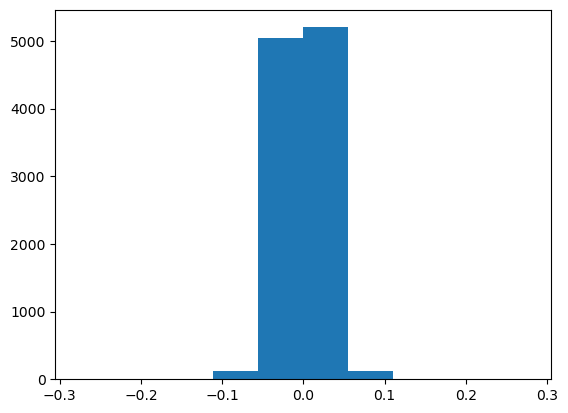

In [49]:
forces = np.vstack([_["F"] for _ in valid_batches])
nonzero = np.nonzero(forces.flatten())[0]
plt.hist(forces.flatten()[nonzero])
# forces

# Example training

In [1]:
# Model initialization
model = EF(
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=16,
    cutoff=5.0,
    max_atomic_number=70,
    charges=False,
    natoms=NATOMS,
    total_charge=0,
    n_res=2,
    zbl=False,
)


# Model training
params = train_model(
    train_key,
    model,
    output1,
    output2,
    num_epochs= int(10**2),
    learning_rate=0.001,
    energy_weight=1,
    schedule_fn="constant",
    optimizer="amsgrad",
    batch_size=BATCH_SIZE,
    num_atoms=NATOMS,
    data_keys=DEFAULT_DATA_KEYS,
    print_freq=1,
    objective="valid_loss",
    best=1e6,
    batch_method="advanced",
    batch_args_dict=batch_kwargs,
)

NameError: name 'EF' is not defined